# Projet ML Classification

On cherche √† vcomparer les performances de plusieurs m√©thodes de classification, dans le cas de Machine learning.

Pour ce travail, on cherchera √† √©valuer si une personne est dite riche ou pauvre, des donn√©es bool√©ennes configur√©e arbitrairement par moi-m√™me.

Classifieurs utilis√©s :
    -AdaBoostClassifier
    -BaggingClassifier
    -SupportVectorMachine (SVM)
    -SGDClassifier

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder

### Base de donn√©e

La base de donn√©e choisir contient plusieurs informations importantes dans la d√©duction du salaire d'une personne, comme son √¢ge ou bien encore son niveau d'√©tude. 

In [5]:
income = pd.read_csv(r'..\data\adult.csv')
income.head()
print(income.head())
income.shape

   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States

(32561, 15)

On choisit de remplacer les donn√©es manquantes par des NaN.

In [6]:
income[income == '?'] = np.nan
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## Pr√©-traitement de la base de donn√©e

Nous allons enlever une colonne qui ne va pas nous servir pour ce que nous cherchons √† pr√©dire, c'est √† dire la colle fnlwgt, colonne qui attribue un num√©ro al√©atoire pour chaque personne de la base de donn√©e. 

In [7]:
income = income.drop([ 'fnlwgt'], axis=1)

income.head()

age workclass     education  education.num marital.status  \
0   90       NaN       HS-grad              9        Widowed   
1   82   Private       HS-grad              9        Widowed   
2   66       NaN  Some-college             10        Widowed   
3   54   Private       7th-8th              4       Divorced   
4   41   Private  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                NaN  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                NaN      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States  <=50K  
2          4356              40  United-States  <=50K  
3          3900              40  United-States  <=50K  
4          3900              40  United-States  <=50K

Puis, pour que l'√©tude soit plus facile, nous allons transformer les valeurs de la colonne income (jusque l√† en string) en variable de type bool√©enne. Ainsi, une personne ayant un salaire de plus de 50 000$ par an (soir riche) sera not√©e comme 1, les "pauvres" seront not√©es comme 0.

In [8]:
income['income'] = income['income'].apply(lambda x: 0 if x.strip() == '<=50K' else 1)

print(income['income'].value_counts())
#print(income.head())

income
0    24720
1     7841
Name: count, dtype: int64


On peut voir que l'on a une trop grande disparit√© entre les pauvres et les riches pour avoir des r√©sultats pertinents.
Pour r√©equilibrer la colonne income, nous allons faire du sous-√©chantillonage de la colonne, 

In [9]:
moins_50k = income[income['income'] == 0 ]
plus_50k = income[income['income'] == 1 ]
moins_50k_echan = moins_50k.sample(len(plus_50k), random_state=42)

income = pd.concat([moins_50k_echan, plus_50k], axis = 0)
income = income.sample(frac = 1, random_state=42).reset_index(drop = True)
print(income['income'].value_counts())
income.info()

income
1    7841
0    7841
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15682 entries, 0 to 15681
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15682 non-null  int64 
 1   workclass       14979 non-null  object
 2   education       15682 non-null  object
 3   education.num   15682 non-null  int64 
 4   marital.status  15682 non-null  object
 5   occupation      14976 non-null  object
 6   relationship    15682 non-null  object
 7   race            15682 non-null  object
 8   sex             15682 non-null  object
 9   capital.gain    15682 non-null  int64 
 10  capital.loss    15682 non-null  int64 
 11  hours.per.week  15682 non-null  int64 
 12  native.country  15409 non-null  object
 13  income          15682 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


In [10]:
income_features = ['age', 'workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']

label_encoders = {}

for col in income_features:
    le = LabelEncoder()
    income[col] = le.fit_transform(income[col])
    label_encoders[col] = le

## Normalisation des donn√©es

In [11]:
scaler = MinMaxScaler()
income[income_features] = scaler.fit_transform(income[income_features])

print(income.head())

        age  workclass  education  education.num  marital.status  occupation  \
0  0.333333      0.000   0.800000             14        0.666667    0.214286   
1  0.492754      0.375   0.733333              9        0.000000    0.000000   
2  0.144928      0.375   0.600000             13        0.666667    0.642857   
3  0.217391      0.375   0.600000             13        0.333333    0.214286   
4  0.434783      0.125   0.800000             14        0.333333    0.642857   

   relationship  race  sex  capital.gain  capital.loss  hours.per.week  \
0           0.2   1.0  0.0          0.88           0.0        0.609195   
1           0.2   1.0  0.0          0.00           0.0        0.436782   
2           0.2   1.0  0.0          0.00           0.0        0.609195   
3           0.0   1.0  1.0          0.77           0.0        0.494253   
4           0.0   1.0  1.0          0.00           0.0        0.666667   

   native.country  income  
0           0.925       1  
1           0.925 

## Affichage de la matrice de corr√©lation

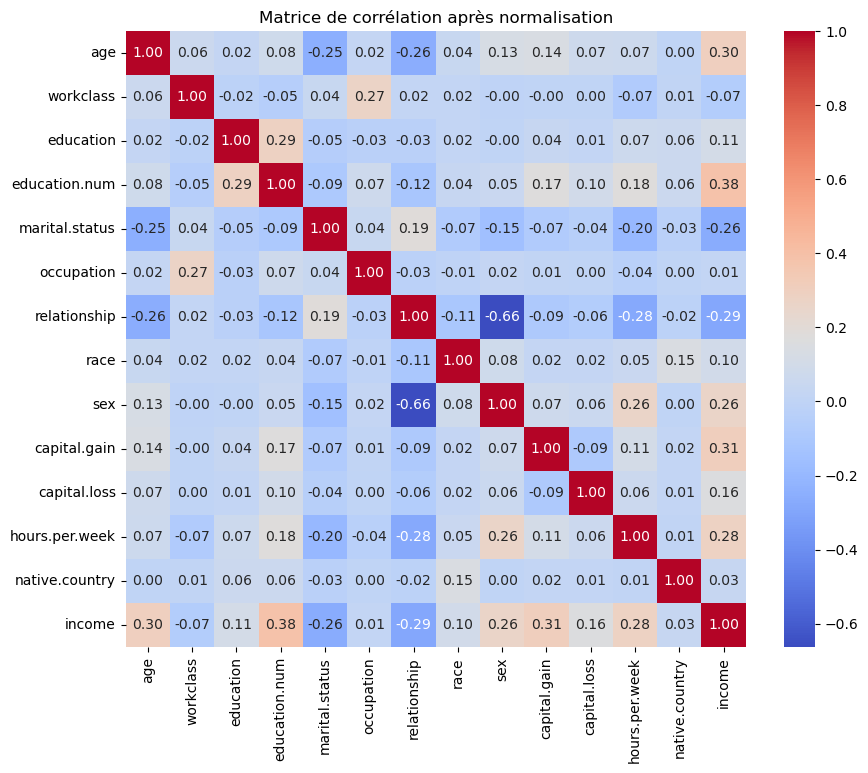

In [12]:
matrice = income.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matrice, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corr√©lation apr√®s normalisation')
plt.show()

Rappel : Interpr√©tation
    Corr√©lation proche de +1 : forte relation positive (si une variable augmente, l'autre aussi).
    Corr√©lation proche de -1 : forte relation n√©gative (si une augmente, l'autre diminue).
    Corr√©lation proche de 0 : pas ou tr√®s peu de relation lin√©aire.

Parmi les corr√©lations les plus significatives avec income, on retrouve :
- education.num (corr√©lation de 0.38) : le niveau d'√©ducation est positivement associ√© au revenu, ce qui est coh√©rent avec l‚Äôid√©e que les individus plus dipl√¥m√©s ont tendance √† gagner davantage.
- capital.gain (0.31) : les gains en capital sont fortement li√©s √† un revenu sup√©rieur.
- age (0.30) : les revenus ont tendance √† augmenter avec l‚Äô√¢ge, probablement en lien avec l‚Äôexp√©rience professionnelle.
- hours.per.week (0.28) : plus une personne travaille d‚Äôheures par semaine, plus elle a de chances d‚Äôavoir un revenu √©lev√©.
- capital.loss (0.16) : bien que la corr√©lation soit plus faible, elle sugg√®re que les pertes en capital peuvent aussi refl√©ter un profil de revenu particulier.
- relationship (-0.29) et marital.status (-0.26) : certaines situations familiales ou maritales sont inversement associ√©es aux revenus √©lev√©s (par exemple, √™tre c√©libataire ou chef de famille sans partenaire).

C'est probablement les features que nous allons choisir pour nos mod√®les.

## Visualisation des outliers

In [13]:
categorical_cols = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
numerical_cols = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

print(income)

            age  workclass  education  education.num  marital.status  \
0      0.333333      0.000   0.800000             14        0.666667   
1      0.492754      0.375   0.733333              9        0.000000   
2      0.144928      0.375   0.600000             13        0.666667   
3      0.217391      0.375   0.600000             13        0.333333   
4      0.434783      0.125   0.800000             14        0.333333   
...         ...        ...        ...            ...             ...   
15677  0.362319      0.375   0.733333              9        0.000000   
15678  0.289855      0.625   0.600000             13        0.333333   
15679  0.275362      0.500   0.733333              9        0.666667   
15680  0.101449      0.750   1.000000             10        0.666667   
15681  0.246377      0.375   0.733333              9        0.666667   

       occupation  relationship  race  sex  capital.gain  capital.loss  \
0        0.214286           0.2   1.0  0.0          0.88     

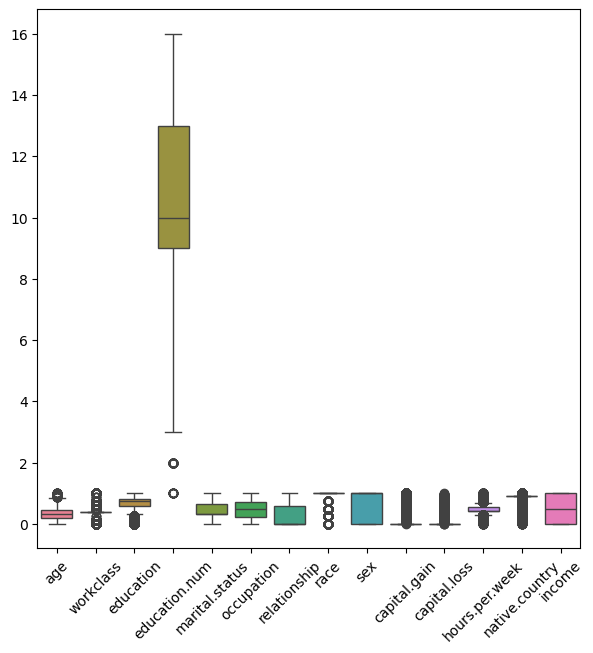

In [14]:
plt.figure(figsize=(7, 7))
sns.boxplot(data=income)
plt.xticks(rotation=45)
plt.show()

#### Analyse par variable
education.num
- Se distingue nettement avec une distribution beaucoup plus large (valeurs entre 1 et 16).
- Cela confirme son importance dans les mod√®les de pr√©diction (comme on l‚Äôa vu dans la matrice de corr√©lation).On voit quelques valeurs extr√™mes faibles, probablement des niveaux d‚Äô√©tudes tr√®s bas

Variables comme capital.gain, capital.loss
- Tr√®s compactes avec beaucoup de valeurs nulles ou proches de z√©ro.
- Les outliers sont clairement visibles, indiquant que peu d‚Äôindividus d√©clarent des gains ou pertes en capital √©lev√©s.

hours.per.week, age
- Distribution plus √©tendue que d'autres variables.
- Leur variabilit√© pourrait √™tre informative pour les mod√®les.

Variables cat√©gorielles encod√©es (workclass, sex, race, etc.)
- Les bo√Ætes sont tr√®s √©troites : ces variables sont encod√©es en valeurs num√©riques discr√®tes, donc leur distribution semble tr√®s "compress√©e".
- Cela rend leur interpr√©tation visuelle moins informative dans ce type de graphique.


Series([], dtype: int64)
            age  workclass  education  education.num  marital.status  \
0      0.333333      0.000   0.800000             14        0.666667   
26     0.304348      0.375   0.666667             16        0.333333   
32     0.289855      0.375   0.533333             11        0.333333   
33     0.434783      0.375   0.800000             14        0.333333   
40     0.521739      0.375   0.466667             12        0.333333   
...         ...        ...        ...            ...             ...   
15646  0.405797      0.625   0.600000             13        0.666667   
15647  0.565217      0.500   0.666667             16        0.333333   
15656  0.028986      1.000   1.000000             10        0.666667   
15659  0.028986      1.000   1.000000             10        0.666667   
15664  0.217391      0.375   0.733333              9        0.333333   

       occupation  relationship  race  sex  capital.gain  capital.loss  \
0        0.214286           0.2   1.

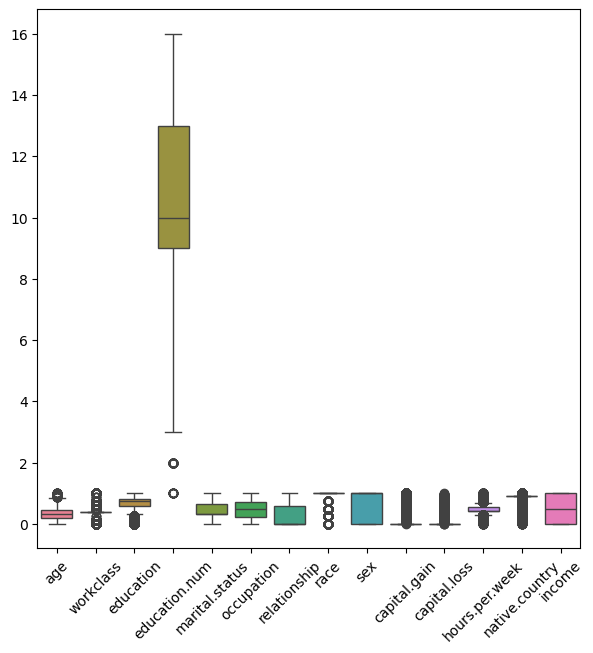

In [15]:
from scipy import stats

missing_values = income.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(missing_values)

mar = income.dropna()

mar.isnull().sum()
z_scores = stats.zscore(mar.select_dtypes(include='number'))

outliers = (z_scores > 3).sum(axis=1)
outlier_rows = mar[outliers > 0]
print(outlier_rows)

plt.figure(figsize=(7, 7))
sns.boxplot(data=mar)
plt.xticks(rotation=45)
plt.show()

#### Choix des features

On choisit donc ces 8 features pour notre √©tudes.

In [16]:
income_features = ['age', 'relationship', 'sex', 'education.num', 'marital.status', 'hours.per.week', 'capital.gain', 'capital.loss']

X = income[income_features]
X.head()

y = income['income']

#### Pr√©paration des donn√©es de test et de train

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("shape of X : ", X.shape)
print("shape of y", y.shape)

shape of X :  (15682, 8)
shape of y (15682,)


## AdaBoost

AdaBoostClassifier - Accuracy : 0.8304
Scores pour chaque fold : [0.91158535 0.9030575  0.90633247 0.91387914 0.90180941]
Score moyen : 0.9073 (+/- 0.0047)



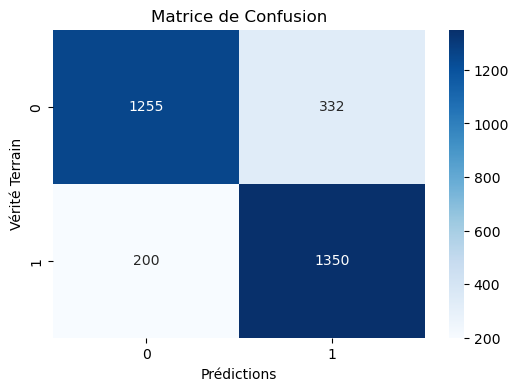

In [18]:
income_ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.7, random_state=None, algorithm='SAMME')
income_ada.fit(X_train, y_train)

y_pred_ada = income_ada.predict(X_test)
y_proba_ada = income_ada.predict_proba(X_test)[:, 1]  

income_ada.score(X_test, y_test)
accuracy_ada = accuracy_score(y_test, y_pred_ada)
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)
"""fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_proba_ada)
auc_score_ada = roc_auc_score(y_test, y_proba_ada)"""

print(f"AdaBoostClassifier - Accuracy : {accuracy_ada:.4f}")

cross_validation_ada = cross_val_score(income_ada, X, y, cv = 5, scoring = "average_precision")
print(f"Scores pour chaque fold : {cross_validation_ada}")
print(f"Score moyen : {np.mean(cross_validation_ada):.4f} (+/- {np.std(cross_validation_ada):.4f})\n")

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_ada, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Pr√©dictions")
plt.ylabel("V√©rit√© Terrain")
plt.show()

#### Cross-validation ADA

In [19]:
cross_validation_ada = cross_val_score(income_ada, X, y, cv = 5, scoring = 'accuracy')
print(f"Scores pour chaque fold : {cross_validation_ada}")
print(f"Score moyen : {np.mean(cross_validation_ada):.4f} (+/- {np.std(cross_validation_ada):.4f})\n")


Scores pour chaque fold : [0.82244182 0.81861651 0.82110969 0.83354592 0.82079082]
Score moyen : 0.8233 (+/- 0.0053)



Courbe ROC AdaBoost

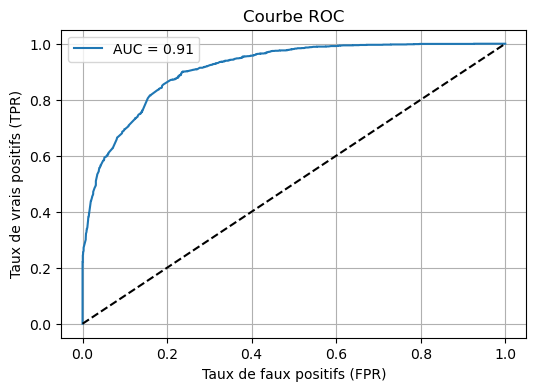

In [20]:
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_proba_ada)
auc_score_ada = roc_auc_score(y_test, y_proba_ada)

plt.figure(figsize=(6,4))
plt.plot(fpr_ada, tpr_ada, label=f"AUC = {auc_score_ada:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend()
plt.grid()
plt.show()

Le mod√®le AdaBoost obtient une excellente pr√©cision moyenne sup√©rieure √† 90 % en validation crois√©e, et se montre √©galement tr√®s stable (√©cart-type faible). Ce mod√®le fonctionne en combinant plusieurs estimateurs faibles (g√©n√©ralement des arbres de d√©cision peu profonds) et en les pond√©rant selon leurs performances, ce qui lui permet de corriger les erreurs des mod√®les pr√©c√©dents √† chaque it√©ration.

Pour r√©sumer, les points forts de ce mod√®le sont :
- Tr√®s bon compromis biais-variance.
- Performant m√™me sans r√©glages approfondis.
- R√©silient aux d√©s√©quilibres mod√©r√©s dans les donn√©es (ce qui est utile ici).

## Bagging

Bagging Classifier - Accuracy : 0.8081


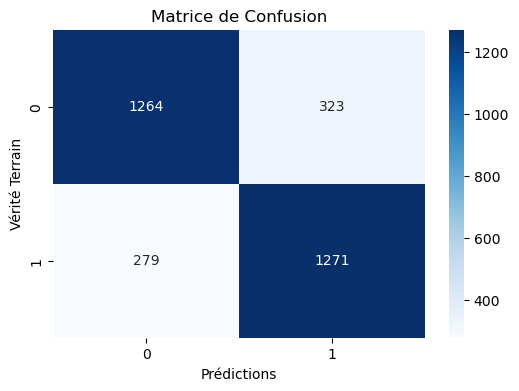

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

bag_classi = BaggingClassifier(n_estimators=300)
bag_classi.fit(X_train, y_train)

y_pred_bag = bag_classi.predict(X_test)
y_proba_bag = bag_classi.predict_proba(X_test)[:, 1]  
bag_classi.score(X_test, y_test)

accuracy_bag = accuracy_score(y_test, y_pred_bag)
conf_matrix_bag = confusion_matrix(y_test, y_pred_bag)

print(f"Bagging Classifier - Accuracy : {accuracy_bag:.4f}")


plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_bag, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Pr√©dictions")
plt.ylabel("V√©rit√© Terrain")
plt.show()

#### cross-validation bagging

In [22]:
cross_validation_bag = cross_val_score(bag_classi, X, y, cv = 5, scoring = 'accuracy')
print(f"Scores pour chaque fold : {cross_validation_bag}")
print(f"Score moyen : {np.mean(cross_validation_bag):.4f} (+/- {np.std(cross_validation_bag):.4f})\n")

Scores pour chaque fold : [0.81957284 0.80618425 0.80867347 0.8182398  0.79432398]
Score moyen : 0.8094 (+/- 0.0092)



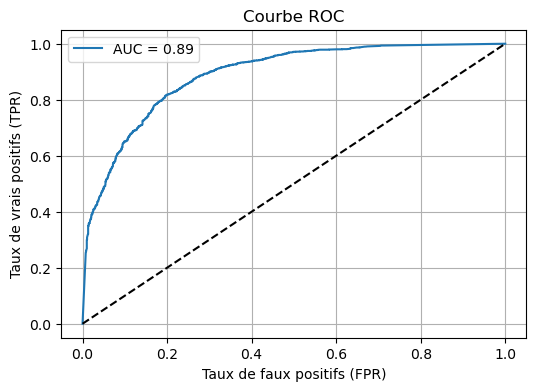

In [23]:
fpr_bag, tpr_bag, thresholds_bag = roc_curve(y_test, y_proba_bag)
auc_score_bag = roc_auc_score(y_test, y_proba_bag)

plt.figure(figsize=(6,4))
plt.plot(fpr_bag, tpr_bag, label=f"AUC = {auc_score_bag:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend()
plt.grid()
plt.show()

## Suppor Vector Machine

Accuracy: 0.763787057698438

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77      1587
           1       0.76      0.76      0.76      1550

    accuracy                           0.76      3137
   macro avg       0.76      0.76      0.76      3137
weighted avg       0.76      0.76      0.76      3137



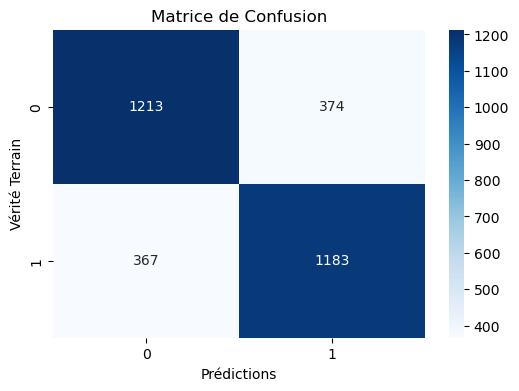

In [24]:
SVM_classi = svm.SVC(kernel = 'linear', C=1.0, probability=True)
SVM_classi.fit(X_train, y_train)
y_pred_SVM = SVM_classi.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_SVM))
print("\nClassification Report:\n", classification_report(y_test, y_pred_SVM))

conf_mat_SVM = confusion_matrix(y_test, y_pred_SVM)
y_proba_SVM = SVM_classi.predict_proba(X_test)[:, 1]  

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat_SVM, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Pr√©dictions")
plt.ylabel("V√©rit√© Terrain")
plt.show()

In [25]:
cross_validation_SVM = cross_val_score(SVM_classi, X, y, cv = 5, scoring = 'accuracy')
print(f"Scores pour chaque fold : {cross_validation_SVM}")
print(f"Score moyen : {np.mean(cross_validation_SVM):.4f} (+/- {np.std(cross_validation_SVM):.4f})\n")

Scores pour chaque fold : [0.7803634  0.76569971 0.76466837 0.77774235 0.75797194]
Score moyen : 0.7693 (+/- 0.0084)



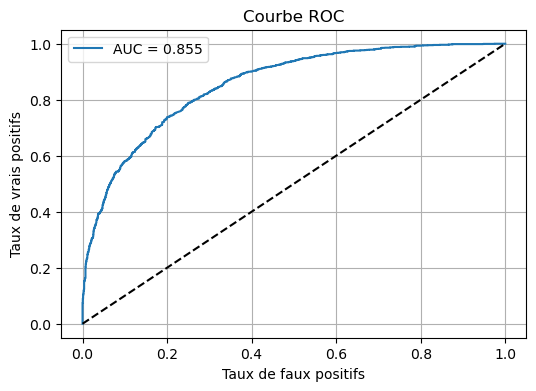

In [26]:
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(y_test, y_proba_SVM)
auc_score_SVM = roc_auc_score(y_test, y_proba_SVM)

plt.figure(figsize=(6,4))
plt.plot(fpr_SVM, tpr_SVM, label=f"AUC = {auc_score_SVM:.3f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend()
plt.grid()
plt.show()

## SGD Classifier

Accuracy: 0.7679311444054829

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77      1587
           1       0.75      0.79      0.77      1550

    accuracy                           0.77      3137
   macro avg       0.77      0.77      0.77      3137
weighted avg       0.77      0.77      0.77      3137



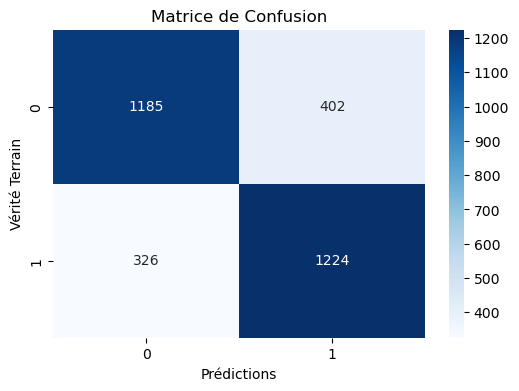

In [27]:
SGD_classifier = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss'))
SGD_classifier.fit(X_train, y_train)

y_pred_SGD = SGD_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_SGD))
print("\nClassification Report:\n", classification_report(y_test, y_pred_SGD))

conf_mat_SGD = confusion_matrix(y_test, y_pred_SGD)
y_proba_SGD = SGD_classifier.predict_proba(X_test)[:, 1]  

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat_SGD, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Pr√©dictions")
plt.ylabel("V√©rit√© Terrain")
plt.show()

In [28]:
cross_validation_SGD = cross_val_score(SGD_classifier, X, y, cv = 5, scoring = 'accuracy')
print(f"Scores pour chaque fold : {cross_validation_SGD}")
print(f"Score moyen : {np.mean(cross_validation_SGD):.4f} (+/- {np.std(cross_validation_SGD):.4f})\n")

Scores pour chaque fold : [0.77526299 0.75709276 0.76020408 0.77359694 0.75350765]
Score moyen : 0.7639 (+/- 0.0088)



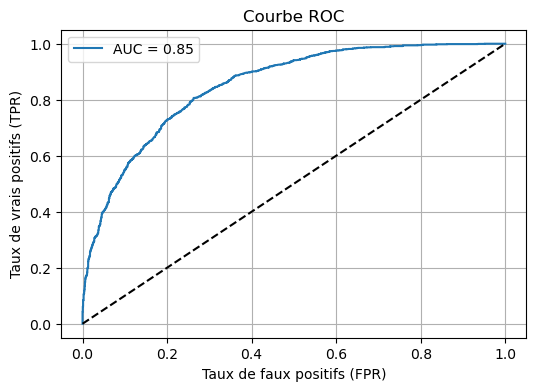

In [29]:
fpr_SGD, tpr_SGD, thresholds_SGD = roc_curve(y_test, y_proba_SGD)
auc_score_SGD = roc_auc_score(y_test, y_proba_SGD)

plt.figure(figsize=(6,4))
plt.plot(fpr_SGD, tpr_SGD, label=f"AUC = {auc_score_SGD:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend()
plt.grid()
plt.show()

### Conclusion de la classification

AdaBoostClassifier s‚Äôest d√©marqu√© comme le plus performant, atteignant une accuracy de 83 % sur le jeu de test et une moyenne de 91 % en validation crois√©e. BaggingClassifier suit avec de bonnes performances (80 %), tandis que SGDClassifier et SVM offrent des r√©sultats plus modestes autour de 76 %.

En conclusion, AdaBoost est le mod√®le le plus adapt√© √† ce jeu de donn√©es. Il combine pr√©cision, stabilit√© et capacit√© √† mod√©liser des relations complexes. Pour am√©liorer davantage les r√©sultats, il serait pertinent d‚Äôexplorer le r√©glage d‚Äôhyperparam√®tres, d‚Äôessayer d‚Äôautres mod√®les ensemblistes comme XGBoost, ou encore d‚Äôappliquer des techniques avanc√©es de s√©lection de variables.

## Nouvelles donn√©es

On va choisir de tester nos mod√®les avec des donn√©es choisis arbitrairement.

In [ ]:
trained_models = {
    "AdaBoost": income_ada,
    "Bagging": bag_classi,    
    "SVM": SVM_classi,
    "SGDClassifier" : SGD_classifier
}

scaler = MinMaxScaler()
scaler.fit(X_train[income_features])

def tester_tous_les_modeles(data_brute, models, scaler, label_encoders, income_features):
    import pandas as pd

    nouvelles_donn√©es = pd.DataFrame([data_brute])

    for col in nouvelles_donn√©es.columns:
        if col in label_encoders:
            encoder = label_encoders[col]
            try:
                nouvelles_donn√©es[col] = encoder.transform(nouvelles_donn√©es[col])
            except ValueError:
                print(f"‚ö†Ô∏è Valeur inconnue pour '{col}' : {nouvelles_donn√©es[col][0]} ‚Üí remplac√©e par -1")
                nouvelles_donn√©es[col] = -1

    try:
        nouvelles_donn√©es = nouvelles_donn√©es[income_features]
        nouvelles_donn√©es = nouvelles_donn√©es.astype(float)
    except KeyError as e:
        print("Erreur : colonne manquante dans les donn√©es :", e)
        return

    try:
        donn√©es_normalis√©es = pd.DataFrame(
            scaler.transform(nouvelles_donn√©es),
            columns=income_features
        )
    except ValueError as e:
        print("Probl√®me de normalisation :", e)
        return

    print("R√©sultats des mod√®les :\n")
    for nom, model in models.items():
        pred = model.predict(donn√©es_normalis√©es)[0]
        proba = model.predict_proba(donn√©es_normalis√©es)[0][1]
        print(f"{nom:10} ‚Üí Classe : {pred} | Probabilit√© >50K : {proba:.2f}")

tester_tous_les_modeles(
    data_brute={
        'age': 45,
        'relationship': 'Husband',
        'sex': 'Male',
        'education.num': 13,
        'marital.status': 'Married-civ-spouse',
        'hours.per.week': 40,
        'capital.gain': 0,
        'capital.loss': 0.1
    },
    models=trained_models,
    scaler=scaler,
    label_encoders=label_encoders,
    income_features=[
        'age', 'relationship', 'sex', 'education.num',
        'marital.status', 'hours.per.week', 'capital.gain', 'capital.loss'
    ]
)



üîé R√©sultats des mod√®les :

AdaBoost   ‚Üí Classe : 0 | Probabilit√© >50K : 0.44
Bagging    ‚Üí Classe : 0 | Probabilit√© >50K : 0.07
SVM        ‚Üí Classe : 1 | Probabilit√© >50K : 1.00
SGDClassifier ‚Üí Classe : 1 | Probabilit√© >50K : 1.00


Nous avons test√© plusieurs mod√®les de machine learning sur une m√™me entr√©e repr√©sentant un individu, afin de pr√©dire s‚Äôil gagne plus ou moins de 50K dollars par an. Voici les r√©sultats obtenus :
| Mod√®le        | Classe pr√©dite | Probabilit√© >50K |
| ------------- | -------------- | ---------------- |
| AdaBoost      | 0 (‚â§50K)       | 0.44             |
| SVM           | 1 (>50K)       | 1.00             |
| Bagging       | 0 (‚â§50K)       | 0.06             |
| SGDClassifier | 1 (>50K)       | 1.00             |

SVM et SGDClassifier pr√©disent que l‚Äôindividu gagne plus de 50K, avec une tr√®s forte certitude (100%). Cela signifie que, pour ces mod√®les, les caract√©ristiques de la personne sont tr√®s repr√©sentatives de profils √† revenu √©lev√©.

AdaBoost, quant √† lui, donne une pr√©diction diff√©rente. Il classe l‚Äôindividu dans la cat√©gorie ‚â§50K, mais avec une probabilit√© de 44% seulement pour >50K, ce qui r√©v√®le une grande incertitude. Le mod√®le est proche de la fronti√®re de d√©cision.

Bagging est plus tranch√©, et classe l‚Äôindividu comme gagnant ‚â§50K, avec une tr√®s faible probabilit√© (6%) d'appartenir √† la classe >50K. Cela montre qu‚Äôil est beaucoup plus conservateur que les autres mod√®les.

Les mod√®les ne sont pas tous d‚Äôaccord :

- Deux mod√®les sont s√ªrs que le revenu est >50K (SVM, SGDClassifier),
- Deux mod√®les penchent pour ‚â§50K, dont un avec faible confiance (AdaBoost).

Cela met en √©vidence l‚Äôint√©r√™t de comparer plusieurs mod√®les, et sugg√®re que dans des cas limites ou proches de la fronti√®re, les mod√®les peuvent diverger.
